In [1]:
%matplotlib inline
from pylab import *

import sys 
sys.path.insert(0, '../')

HIP = 16537 # epsilon eridani

'''
Load EXOCAT and Computational classes
'''
import pandas
exocat = pandas.read_excel('../ExoCat1.xls', header=0)
gp = pandas.read_excel("../EKGPS.xls")

# Initialize Star model.
from Star import Star
i_entry = np.where(exocat['HIP'] == HIP)[0][0]
exocat_star =  exocat.iloc[i_entry]

print('exocat_star[\'COMMON\']: ', exocat_star['COMMON'])

star_model = Star(L_bol = exocat_star['Lbol'], d_pc = exocat_star['d(pc)'], Temperature=exocat_star['Teff'], Mass = exocat_star['M*(Msun)'], MV = exocat_star['Mv'])

# initialize solar system zodi model.
from Zodi import Zodi
zodi_model = Zodi('../')

# initialize observatory model.
from Observatory_Position_and_Time import Observatory_Position_and_Time
obs_PT = Observatory_Position_and_Time(exocat_star['RA(ICRS)'], exocat_star['DE(ICRS)'])

# initialize exozodi model.
from Exozodi import Exozodi
exozodi_model = Exozodi()

# import detector model (initialize in calculation loop).
from Detector import Detector

# Initialize completeness (Monte Carlo) calculator
from Completeness import Completeness_MC_Calculator
CMC_calc = Completeness_MC_Calculator(LUT_path = './')

print('Finished Importing Libraries')


exocat_star['COMMON']:  epsilon Eridani
Finished Importing Libraries


In [2]:
######################################################
# Set ranges of input parameters

e2e_throughput_array = np.array([4.5e-2])
contrast_array       = np.array([1.e-10])
IWA_array            = np.array([100.])
nzodi_array          = np.array([4.5])
planet_radius_array  = np.array([6371.]) # km
img_SNR_cuts         = np.array([5.])
spc_SNR_cuts         = np.array([20.])
T_int_array          = np.array([1.*60**2*24, 3.*60**2*24, 6.*60**2*24]) # in seconds

'''
Initialize Completeness Matrix
'''
# loop order
# e2e_throughput, Contrast, IWA (defines detector)
# nzodi, planet radius (assumptions about nature)
# SNR_cuts, integration time
N_results = 7
Completeness_matrix = -1*np.ones((len(e2e_throughput_array),
                                  len(contrast_array),
                                  len(IWA_array),
                                  len(nzodi_array),
                                  len(planet_radius_array),
                                  len(img_SNR_cuts),
                                  len(T_int_array),
                                  N_results # single-visit, at least 1, 2, 3, 4 successes
                                  ))

'''
Get observing windows
'''
init_date = '2029/1/1'
duration_days = 2*366 # two years
obs_PT.get_observing_windows(init_date, duration_days, sun_ang_min=54., sun_ang_max=83.)
print( 'observing time windows', obs_PT.starts, obs_PT.durations)
obs_time_array = obs_PT.starts
obs_time_durations = obs_PT.durations
print( '*observing time array', obs_time_array, obs_PT.durations)
# we want 4 visits
# remove observation windows that are too short
id_good = np.where(obs_time_durations>16)[0]
print( 'id_good', id_good)
obs_time_array     = obs_time_array[id_good] 
obs_time_durations = obs_time_durations[id_good]
print( '*observing time array', obs_time_array, obs_time_durations)

while(len(obs_time_array)<4):
    # find the longest time window and split it
    idx = np.argmax(obs_time_durations)
    print( obs_time_array[idx], obs_time_durations[idx])
    obs_time_array = np.concatenate([obs_time_array[0:idx], 
                                      [obs_time_array[idx]], 
                                      [obs_time_array[idx]+obs_time_durations[idx]//2], 
                                      obs_time_array[idx+1:] ])
    obs_time_durations = np.concatenate([obs_time_durations[0:idx], 
                                         [obs_time_durations[idx]-obs_time_durations[idx]//2], 
                                         [obs_time_durations[idx]//2], 
                                         obs_time_durations[idx+1:]])
print( '*observing time array', obs_time_array, obs_time_durations)
'''
Initialize Imaging and Reference Spectroscopy Bands
'''
img_wl_1 = 615.e-9 # imaging band lower frequency
img_wl_2 = 800.e-9 # imaging band upper frequency
spc_wl_1 = 725.e-9 - 14.35e-9/2. # spectral sub-band lower frequency, R=50
spc_wl_2 = 725.e-9 + 14.35e-9/2. # spectral sub-band upper frequency, R=50

'''
Loop Through Parameters
'''
count = 0
import time

# note: imaging e2e througput is  6.9% (based on CGI requirements), spectral  4.5% (based on CGI requirements)
imaging_detector_model = Detector(Diameter=2.37, 
                                  throughput=0.045*(0.44/0.29),               
                                  quantum_efficiency=1.,  # throughput value includes this already.
                                  contrast=1.e-10,        # current requirement 
                                  band=[img_wl_1, img_wl_2], 
                                  PSF_diameter_mas = 65.)

spectrum_detector_model = Detector(Diameter=2.37,
                                   throughput=0.045,
                                   quantum_efficiency=1.,
                                   contrast=1.e-10,
                                   band=[spc_wl_1, spc_wl_2],
                                   PSF_diameter_mas = 65.)
 


observing time windows [ 45 179 411 544] [34 35 33 35]
*observing time array [ 45 179 411 544] [34 35 33 35]
id_good [0 1 2 3]
*observing time array [ 45 179 411 544] [34 35 33 35]
*observing time array [ 45 179 411 544] [34 35 33 35]


10000.0
0.7856


Text(0.5, 0, 'Period, years')

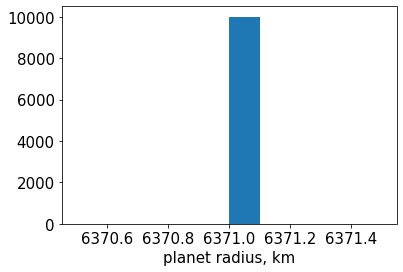

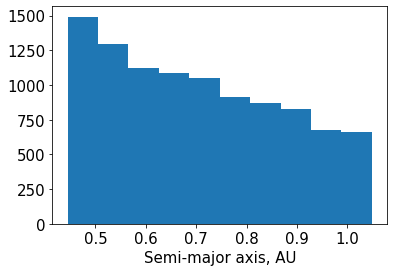

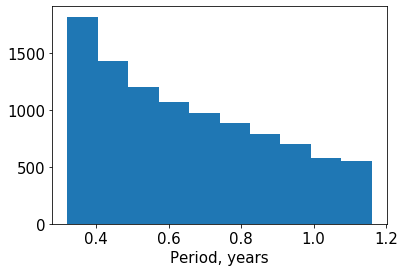

In [3]:
# Run this once for the planet simulation part (should eventually make this part its own class)
C = CMC_calc.Completeness(
        star_model,
        imaging_detector_model,
        zodi_model,
        exozodi_model,
        obs_PT,
        n_zodi=3., # current best estimate
        reference_inner_orbital_radius_AU = 0.75,
        reference_outer_orbital_radius_AU = 1.77,
        planet_radius_km = 6371., # Earth
        geometric_albedo = 0.200,
        T_int            = 24.*60.**2, # seconds
        t_obs_days       = obs_time_array,
        IWA_lim_mas      = 100, # we cycle through this in the loop below
        SNR_cut          = 5.,# we cycle through this in the loop below
        num_samples      = 10000,
        scale_radius = True,
        diagnostic_plots = False)

npoints = float(CMC_calc.cut.shape[1])
print (npoints)
print (C)

hist(CMC_calc.planet_radius_km)
xlabel('planet radius, km')
figure()
hist(CMC_calc.K_a_SM_AU)
xlabel('Semi-major axis, AU')
figure()
hist(CMC_calc.K_Period_seconds/CMC_calc.year_in_seconds)
xlabel('Period, years')

100000.0
0.78886
1136.5431404771286
1928.0258490813935


Text(0.5, 0, 'Geometric Albedo')

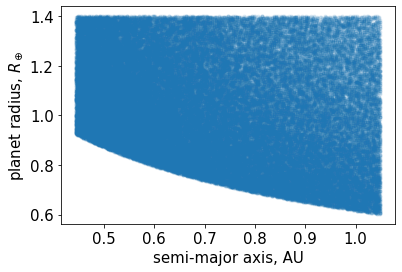

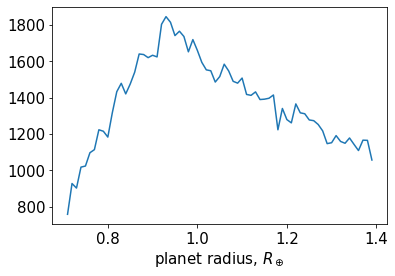

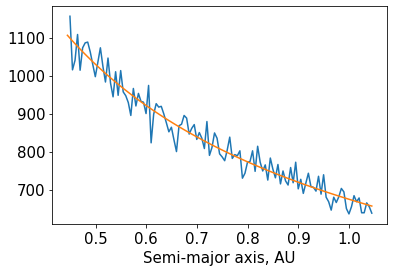

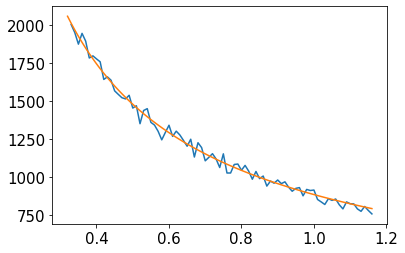

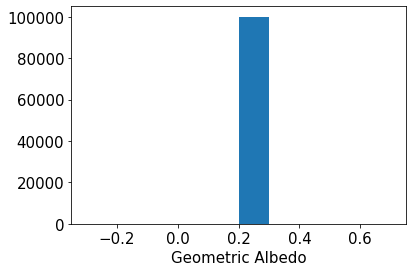

In [4]:
# Run this once for the planet simulation part (should eventually make this part its own class)
C = CMC_calc.Completeness(
        star_model,
        imaging_detector_model,
        zodi_model,
        exozodi_model,
        obs_PT,
        n_zodi=3., # current best estimate
        reference_inner_orbital_radius_AU = 0.75,
        reference_outer_orbital_radius_AU = 1.77,
        planet_radius_km = 6371., # Earth
        geometric_albedo = 0.200,
        #geometric_albedo_min = 0.025,
        #geometric_albedo_max = 0.043,
        T_int            = 24.*60.**2, # seconds
        t_obs_days       = obs_time_array,
        IWA_lim_mas      = 100, # we cycle through this in the loop below
        SNR_cut          = 5.,# we cycle through this in the loop below
        num_samples      = 100000,
        scale_radius = True,
        sampling_mode = 'HabEx', 
        min_planet_radius_km    = 0.8*6371.,
        max_planet_radius_km = 1.4*6371.,
        diagnostic_plots = False)

npoints = float(CMC_calc.cut.shape[1])
print (npoints)
print (C)

figure()
plot(CMC_calc.K_a_SM_AU, CMC_calc.planet_radius_km/6371., '.', alpha=0.1)
ylabel('planet radius, $R_\oplus$')
xlabel('semi-major axis, AU')

figure()
#hist(CMC_calc.planet_radius_km)
alpha = -0.19
beta  = +0.26
rad = np.arange(6371.*0.7, 6371.*1.4, 6371.*0.01)
h,b = np.histogram(CMC_calc.planet_radius_km, bins=rad)
plot(b[1:]/6371.,h)
#norm = np.median(h/(rad[1:]**(alpha-1.)))
#print np.max(h)/np.max(rad**alpha)
#plot(rad, (rad**(alpha-1.))*norm)
xlabel('planet radius, $R_\oplus$')

delta = 1.5*beta
#delta = beta
figure()
sma = np.arange(np.min(CMC_calc.K_a_SM_AU),
                np.max(CMC_calc.K_a_SM_AU),               
               0.005)
h,b = np.histogram(CMC_calc.K_a_SM_AU, bins=sma)
plot(b[1:],h)
norm = np.median(h/(sma[1:]**(delta-1.)))
print (np.max(h)/np.max(sma**delta))
plot(sma, (sma**(delta-1.))*norm)
xlabel('Semi-major axis, AU')


figure()
per = np.arange(np.min(CMC_calc.K_Period_seconds/CMC_calc.year_in_seconds),
                np.max(CMC_calc.K_Period_seconds/CMC_calc.year_in_seconds),               
               0.01)
h,b = np.histogram(CMC_calc.K_Period_seconds/CMC_calc.year_in_seconds, bins=per)
plot(b[1:],h)
norm = np.median(h/(per[1:]**(beta-1.)))
print (np.max(h)/np.max(per**beta))
plot(per, (per**(beta-1.))*norm)

figure()
hist(CMC_calc.geometric_albedo)
xlabel('Geometric Albedo')
